# Out-of-distribution detection with Score-based Generative models

To do: add image of the method


## Introduction

1. Train a time-dependent score model as (Song et.al.)
2. Load the train model

In [1]:
from models import utils as mutils
import datasets
import sde_lib
import sampling 

import os
import torch
import numpy as np
import importlib.util
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import tqdm

config_dir="./configs/vp/mnist_config.py"
workdir="./results/mnist"
mode="eval"

In [2]:
# Load config file
spec = importlib.util.spec_from_file_location("config_file", config_dir)
foo = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo)
config=foo.get_config()

In [3]:
# Load trained model and corresponding SDE

# Setup SDEs
if config.training.sde.lower() == "basic_sde":
    sde = sde_lib.BASIC_SDE(sigma=config.model.sigma_max, N=config.model.num_scales)
    sampling_eps = 1e-3
else:
    raise NotImplementedError(f"SDE {config.training.sde} unknown.")


# Initialize model
score_model = mutils.create_model(config, sde)
score_model = torch.nn.DataParallel(score_model)
score_model = score_model.to(config.device)

# load model
ckpt = torch.load(os.path.join(workdir,'ckpt.pth'), map_location=config.device)
score_model.load_state_dict(ckpt)

<All keys matched successfully>

In [4]:
# Building sampling functions

inverse_scaler = datasets.get_data_inverse_scaler(config)

sampling_shape = (config.training.batch_size, config.data.num_channels,
                  config.data.image_size, config.data.image_size)
sampling_fn = sampling.get_sampling_fn(config, sde, sampling_shape, inverse_scaler, sampling_eps)



In [5]:
# get samples given the score_model
samples, n = sampling_fn(score_model)

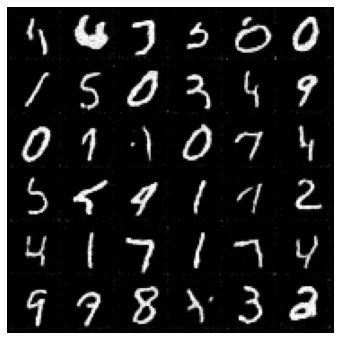

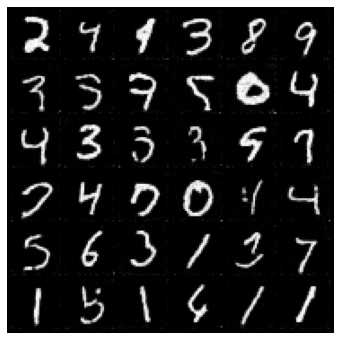

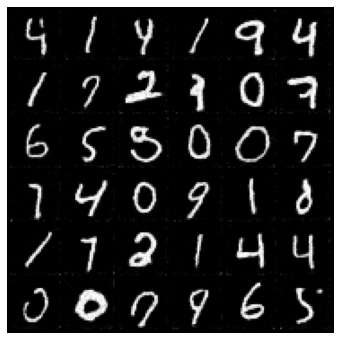

In [6]:
## Sample visualization with PC
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(3):
    sample_grid = make_grid(samples[i*36:(i+1)*36], nrow=int(np.sqrt(36)))
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu())
    plt.show()

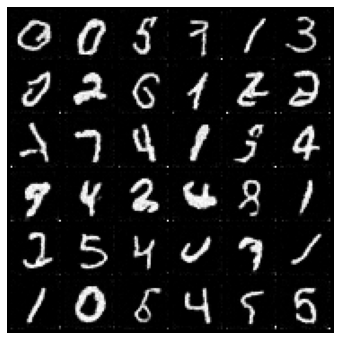

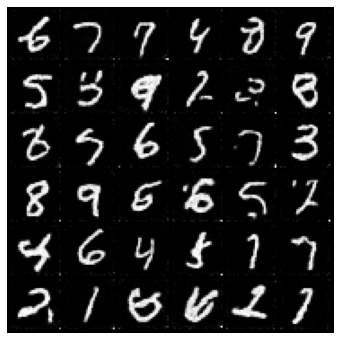

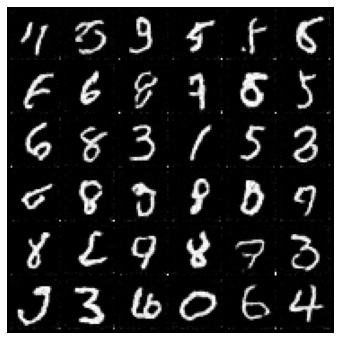

In [6]:
## Sample visualization only with Predicto (Euler-Maruyama)
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(3):
    sample_grid = make_grid(samples[i*36:(i+1)*36], nrow=int(np.sqrt(36)))
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu())
    plt.show()

## Get scores at each time step

In [13]:
import torchvision
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms

In [14]:
# Build data iterators
train_ds, eval_ds = datasets.get_dataset(config)
data_loader = DataLoader(train_ds, batch_size=config.training.batch_size, shuffle=True, num_workers=4)
eval_loader = DataLoader(eval_ds, batch_size=config.training.batch_size, shuffle=True, num_workers=4)


ood_ds = FashionMNIST('data/', train=True, transform=transforms.ToTensor(), download=True)  
ood_data_loader = DataLoader(ood_ds, batch_size=config.training.batch_size, shuffle=True, num_workers=4)


x, y = next(iter(data_loader))
x = x.to(config.device)
 
x_ood, _ = next(iter(ood_data_loader))
x_ood = x_ood.to(config.device)

In [30]:
def diffuse_data(x, 
               sde, 
               score_model,  
               num_steps,  
               eps=1e-3,
               device='cuda'):
    """ Euler-Maruya update 
    x_n+1 = x_n + f(x_n)dt + sqrt(dt) G(u_t) z ; z~N(0,I)
    """

    score_fn = mutils.get_score_fn(sde, score_model, train=False, continuous=True)


    # define the forward time partition from [T,0)
    time_steps = torch.linspace(eps, sde.T, num_steps, device=config.device)
    dt = time_steps[1] - time_steps[0]

    grad_norms = []
    xs = []
    xs.append(x)


    with torch.no_grad():
        for t in tqdm.notebook.tqdm(time_steps): 
            vect_t = torch.ones(x.shape[0], device=config.device) * t
            
            # update time dependent forward sde to get the values of the drif and diffusion coefficients
            drift, diffusion = sde.sde(x, vect_t)

            # Evaluate the score at x_n
            grad = score_fn(x, vect_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1) 

            # Update x_n
            z = torch.randn_like(x)
            x = x + drift*dt + diffusion[:, None, None, None] * torch.sqrt(dt) * z

            # save 
            xs.append(x)
            grad_norms.append(grad_norm) 

    xs = torch.stack(xs, dim=1)
    grad_norms = torch.stack(grad_norms, dim=1)

    return xs, grad_norms

In [31]:
xs, grad_norms = diffuse_data(x, sde, score_model, 200)

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 0, 'Diffussion time')

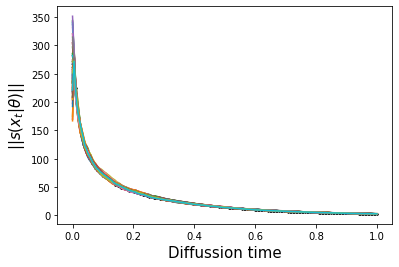

In [35]:
ts = np.linspace(0,1, grad_norms.shape[-1])
plt.plot(ts, grad_norms[i].cpu().numpy(), "k",  marker=".", markersize=3)
for i in range(100): 
    plt.plot(ts, grad_norms[i].cpu().numpy(), markersize=10) 
plt.ylabel(r"$||s(x_t|\theta)||$", fontsize=15)
plt.xlabel("Diffussion time", fontsize=15)

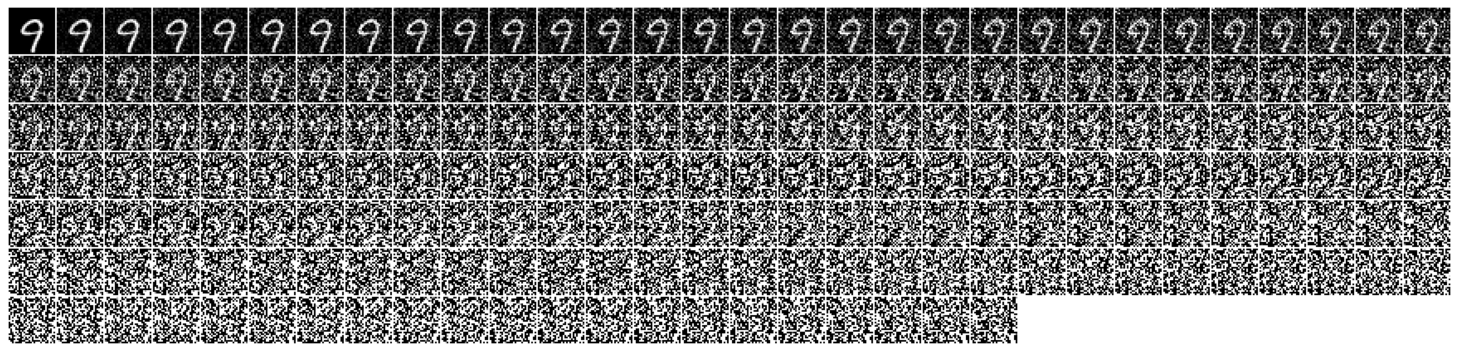

In [40]:
xs = xs.clamp(0.0, 1.0)
x_diffused = xs[3]
ncol = 30
rescale = 2
grid_img = torchvision.utils.make_grid(x_diffused.data.cpu(), nrow=ncol, pad_value=1, padding=1)
fig = plt.figure(figsize=(ncol*5/rescale,5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.tight_layout()

## 

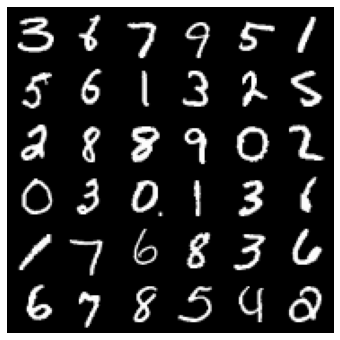

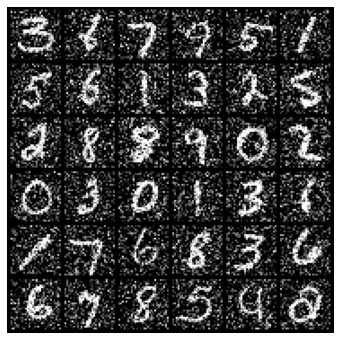

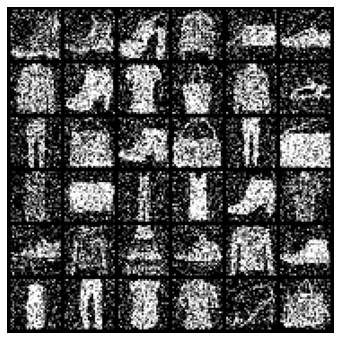

In [44]:
## Sample visualization. 
%matplotlib inline
import matplotlib.pyplot as plt
 
sample_grid = make_grid(x[:36], nrow=int(np.sqrt(36)))
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu())
plt.show()


# intermediate diffusion
t= .1
vect_t = torch.ones(x.shape[0], device=config.device) * t
x_mean, marginal_prob_std = sde.marginal_prob(x, vect_t)
    
x_T = x_mean + torch.randn(x.shape[0], 1, 28, 28, device=config.device) * marginal_prob_std[:, None, None, None]
samples = x_T.clamp(0.0, 1.0)
sample_grid = make_grid(samples[:36], nrow=int(np.sqrt(36)))
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu())
plt.show()


# x_T_ood = x_ood.to(device) + torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t, sigma)
# samples = x_T_ood.clamp(0.0, 1.0)
# sample_grid = make_grid(samples[:36], nrow=int(np.sqrt(36)))
# plt.figure(figsize=(6,6))
# plt.axis('off')
# plt.imshow(sample_grid.permute(1, 2, 0).cpu())
# plt.show()


vect_t = torch.ones(x_ood.shape[0], device=config.device) * t
x_mean, marginal_prob_std = sde.marginal_prob(x_ood, vect_t)
    
x_T = x_mean + torch.randn(x_ood.shape[0], 1, 28, 28, device=config.device) * marginal_prob_std[:, None, None, None]
samples = x_T.clamp(0.0, 1.0)
sample_grid = make_grid(samples[:36], nrow=int(np.sqrt(36)))
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu())
plt.show()

In [141]:
x_mean.shape

torch.Size([128, 1, 28, 28])

In [142]:
x.shape[0]

128

In [144]:
marginal_prob_std.shape

torch.Size([128])